# Adult dataset imputation

Data imputation notebook for the Adult dataset

**NOTE**: most of the preliminary analysis (except from the pandas profiling) is done with one of the dataset containing missing values (the 90% one) because we are simulating a real scenario in which the 'perfect' dataset is not available to us.

In [38]:
import pandas as pd
import numpy as np
import utility.dirty_completeness as dc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('darkgrid')
%matplotlib inline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

import warnings
warnings.simplefilter(action='ignore')
seed = 11

df_adult = pd.read_csv('../datasets/adult.csv')
df_list_adult = dc.injection(df_adult, 1, 'adult', 'income')

df_90 = df_list_adult[4]

saved adult-completeness50%
saved adult-completeness60%
saved adult-completeness70%
saved adult-completeness80%
saved adult-completeness90%


### Data Profiling
First of all we take a look at the dataset to have a better idea of what we are working with 

In [39]:
import pandas_profiling as pp
profile_adult = pp.ProfileReport(df_adult, title="Adult profiling")
#profile_adult.to_file("adult_profiling.html")
#profile_adult.to_file("../profilingReports/adult_profiling.json")

In [40]:
import json as j
f = open("../profilingReports/adult_profiling.json")
jfile = j.load(f)

In [41]:
df_adult.head(5)

,age,workclass,fnlwgt,education,education-num,maritial-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,42,Self-emp-not-inc,99185,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
1,55,Private,163083,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
2,49,Private,340755,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,>50K
3,31,Private,208881,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
4,19,Private,271446,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,25,United-States,<=50K


Let's take a look at the features to separate categorical and numerical ones.

In [42]:
df_90.nunique()

age                  68
workclass             6
fnlwgt             2595
education            16
education-num        16
maritial-status       7
occupation           13
relationship          6
race                  5
sex                   2
capital-gain         58
capital-loss         37
hours-per-week       73
native-country       38
income                2
dtype: int64

By looking at the `nunique()` output and the [Dataset documentation](https://archive.ics.uci.edu/ml/datasets/adult) we can figure out which features are categorical and which are numerical. A good amount of them are numerical but the majority is categorical. We will of course handle them differently in our analysis.


In [43]:
categorical = ['workclass', 'education', 'maritial-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
columns = categorical + numerical

### Correlation analysis

The profiling operation suggested that there were some very simple dependencies that could be explited for the imputation process:

- relationship and sex
    - Husband -> Male
    - Wife -> Female
- education and education-num

Below are some visualizations to verify the hypothesis

NOTE: to do the visualization we use the 90% dataset. The functional dependencies hold true for the other datasets aswell but of course with lower support

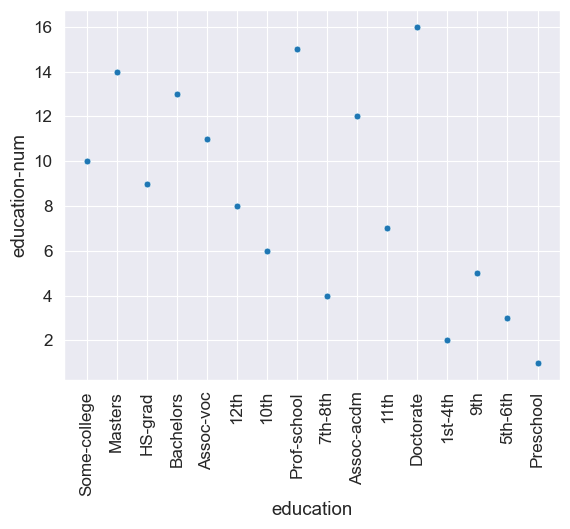

In [44]:
sns.scatterplot(df_90[['education', 'education-num']], x='education', y='education-num')
plt.xticks(rotation=90);

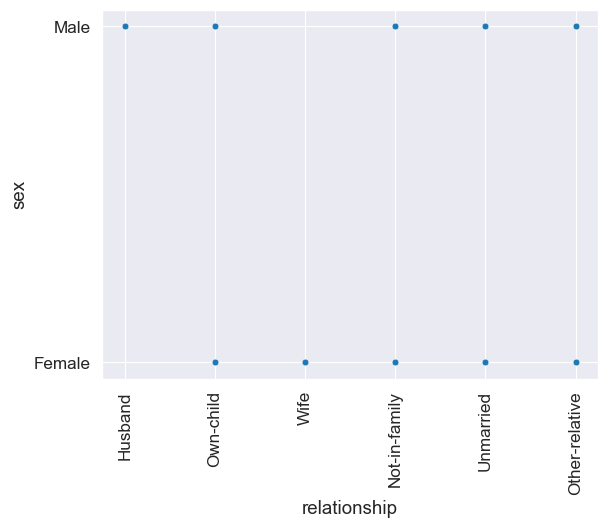

In [45]:
sns.scatterplot(df_90[['relationship', 'sex']], x='relationship', y='sex')
plt.xticks(rotation=90);

If you still are not convinced here is further proof of the correlation from the pandasProfiling library that clearly shows that: 
- education and education-num are perfectly correlated
- sex and relationship are somewhat correlated

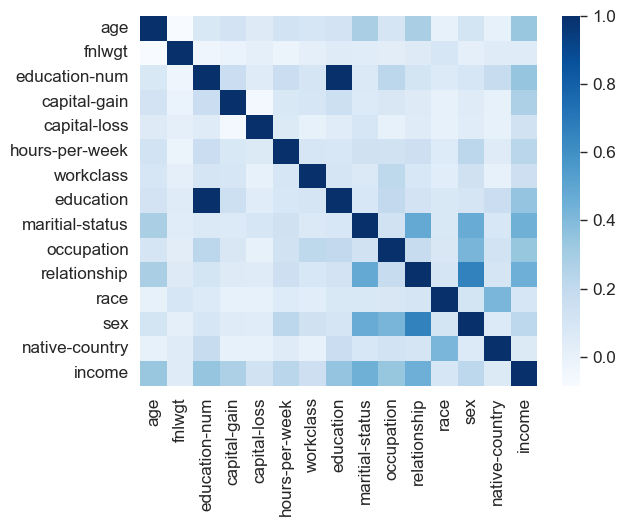

In [46]:
labels = list(jfile["correlations"]["auto"][0].keys())

df_correlation = pd.DataFrame(jfile["correlations"]["auto"])
sns.heatmap(df_correlation, cmap='Blues', yticklabels=labels)
plt.xticks(rotation=90);

now that we discovered the functional dependencies let's create 2 dictionaries that will help us exploit them for the imputation process

In [47]:
sex_dict = {'Husband': 'Male', 'Wife': 'Female'}
print(sex_dict)

{'Husband': 'Male', 'Wife': 'Female'}


In [48]:
sub_df = df_90[['education', 'education-num']]
sub_df.dropna(inplace=True)
sub_df.drop_duplicates(subset=['education-num'], keep='first', inplace=True)
sub_df.set_index('education-num', inplace=True)
sub_df.sort_index(inplace=True)

temp_dict = sub_df.to_dict()
education_dict = temp_dict['education']
education_dict

{1.0: 'Preschool',
 2.0: '1st-4th',
 3.0: '5th-6th',
 4.0: '7th-8th',
 5.0: '9th',
 6.0: '10th',
 7.0: '11th',
 8.0: '12th',
 9.0: 'HS-grad',
 10.0: 'Some-college',
 11.0: 'Assoc-voc',
 12.0: 'Assoc-acdm',
 13.0: 'Bachelors',
 14.0: 'Masters',
 15.0: 'Prof-school',
 16.0: 'Doctorate'}

### Initial imputation using functional dependencies

In [49]:
df_list_adult[0][['education', 'education-num']].isnull().sum()

education        1472
education-num    1489
dtype: int64

In [50]:
df_list_adult[0][['relationship', 'sex']].isnull().sum()

relationship    1510
sex             1514
dtype: int64

In [51]:
df_list_adult_functional_dep = []
for dataframe in df_list_adult:
    df = dataframe.copy()
    for en, e in zip(education_dict.keys(), education_dict.values()):
        df.loc[df['education'] == e, 'education-num'] = en
        df.loc[df['education-num'] == en, 'education'] = e

    for rel, sex in zip(sex_dict.keys(), sex_dict.values()):
        df.loc[df['relationship'] == rel, 'sex'] = sex
    df_list_adult_functional_dep.append(df)

Let's check that only rows that had both education and education-num at the same time to NaN are left

In [52]:
df_list_adult_functional_dep[0][['education', 'education-num']].isnull().sum()

education        729
education-num    729
dtype: int64

For example as you can see we imputed about 700 NaN values in an exact way in the 50% dataset using this simple Functional Dependency. 

Similar considerations can be done for relationship and sex where the sex feature gets imputed using some of the relationship values

In [53]:
df_list_adult_functional_dep[0][['relationship', 'sex']].isnull().sum()

relationship    1510
sex             1173
dtype: int64

---

### Simple Imputation

for the simple imputation we are using:
- the median for numerical features
- the most frequent value for categorical features

In [54]:
imputed_df_list = []
for df in df_list_adult_functional_dep:
    # imputate numerical values using the median
    df_numerical = df[numerical].copy()
    simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='median') #define the imputer model
    adult_numerical_imp = simple_imputer.fit_transform(df_numerical) # returns numpy array
    df_numerical_imputed = pd.DataFrame(adult_numerical_imp, columns=numerical)

    # imputate categorical values using the most frequent value
    df_cat = df[categorical].copy()
    simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent') #define the imputer model
    adult_categorical_imp = simple_imputer.fit_transform(df_cat) # returns numpy array
    df_categorical_imputed = pd.DataFrame(adult_categorical_imp, columns=categorical)

    imputed_df = pd.concat([df_numerical_imputed, df_categorical_imputed, df['income']], axis=1)

    imputed_df_list.append(imputed_df)

In [55]:
# check that no NaN is left
for df in imputed_df_list:
    print(df.isnull().sum().sum())

0
0
0
0
0


Now let's evaluate the accuracy of the 5 datasets

In [56]:
from utility.utility import accuracy_assesment

basic = accuracy_assesment(imputed_df_list, df_adult, columns = columns, numeric_columns=numerical)

basic_list = list(basic.values())

basic

{'50%': 0.8844888245196189,
 '60%': 0.9075408996976347,
 '70%': 0.9338919294048017,
 '80%': 0.9561400837098046,
 '90%': 0.9782012176323178}

---

### Advanced Imputation

For the advanced we are using a modified version of the MICE algorithm seen in class that is able to handle both *regression* and *classification* using:
- KNeighborsRegressor
- KNeighborsClassifier

In [57]:
from utility.utility import iterative_imputation_KNN

imputed_df_list_advanced = []
for df in df_list_adult_functional_dep:
    imputed_df = iterative_imputation_KNN(df, 'income', numerical)
    imputed_df_list_advanced.append(imputed_df)

loading: [===============] 100.0%
loading: [===============] 100.0%
loading: [===============] 100.0%
loading: [===============] 100.0%
loading: [===============] 100.0%


In [58]:
# check that no NaN is left
for df in imputed_df_list_advanced:
    print(df.isnull().sum().sum())

0
0
0
0
0


In [59]:
from utility.utility import accuracy_assesment

advanced = accuracy_assesment(imputed_df_list_advanced, df_adult, columns = columns, numeric_columns=numerical)

advanced_list = list(advanced.values())

advanced

{'50%': 0.8894872478461912,
 '60%': 0.9122689533191014,
 '70%': 0.9409478872117509,
 '80%': 0.9631077468193032,
 '90%': 0.9815860080811109}

### Final considerations on imputation

The advanced imputation with MICE performs slightly better that the basic one but the computational cost is completely different. 

MICE is about 150x slower than the simple method. For a much bigger dataset it could become a problem.

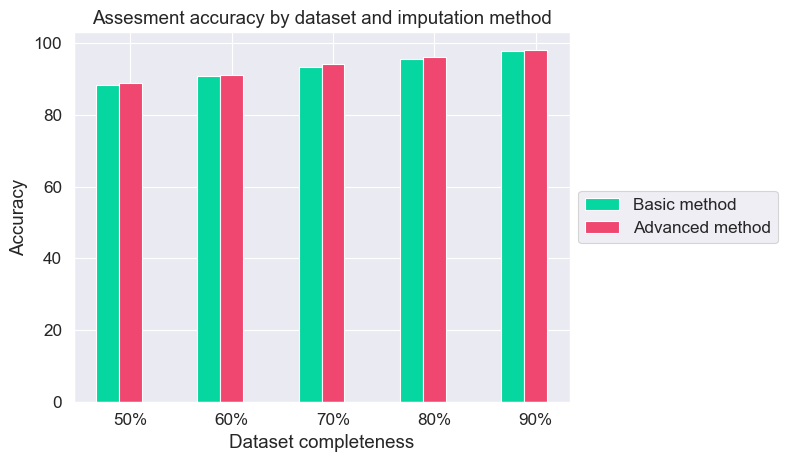

In [60]:
labels = [f'{p}%' for p in range(50, 100, 10)]


advanced_distance = np.array(advanced_list) * 100
basic_distance = np.array(basic_list) * 100

x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/4, basic_distance, width / 4, label='Basic method', color='#06d6a0')
rects2 = ax.bar(x , advanced_distance, width / 4, label='Advanced method', color='#ef476f')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Dataset completeness')
ax.set_title('Assesment accuracy by dataset and imputation method')
ax.set_xticks(x, labels)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

But if I wanted for some reason to convince you that you absolutely need MICE imputation I would show you this quite misleading graph. I simply changed the scale to not start at 0.

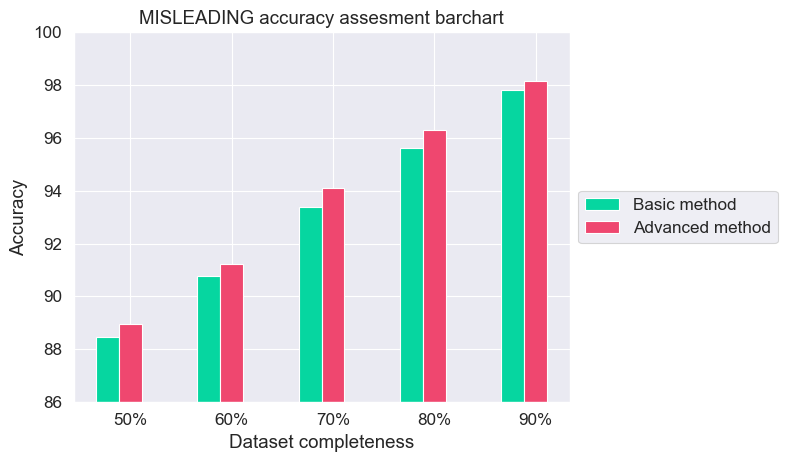

In [61]:
labels = [f'{p}%' for p in range(50, 100, 10)]


advanced_distance = np.array(advanced_list) * 100
basic_distance = np.array(basic_list) * 100

x = np.arange(len(labels))  # the label locations
width = 0.9  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/4, basic_distance, width / 4, label='Basic method', color='#06d6a0')
rects2 = ax.bar(x , advanced_distance, width / 4, label='Advanced method', color='#ef476f')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Dataset completeness')
ax.set_title('MISLEADING accuracy assesment barchart')
ax.set_xticks(x, labels)
ax.set_ylim([86,100])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

---
## Training the ML algorithms

in this section we will train 2 different ML algorithms for classification and compare the performances obtained with the 5 different varsions of the adult dataset.

Before making any prediction we:
- get rid of duplicates present in the dataset
- transform with one hot encoding the categorical variables
- normalize the numerical values with zscore

In [62]:
# asses the number of duplicates
for df in imputed_df_list:
    print(df[df.duplicated(keep='first')].shape[0])

for df in imputed_df_list_advanced:
    print(df[df.duplicated(keep='first')].shape[0])

227
103
29
5
2
296
132
28
3
2


Let's get rid of duplicates

In [63]:
for df in imputed_df_list:
    df.drop_duplicates(inplace=True)

for df in imputed_df_list_advanced:
    df.drop_duplicates(inplace=True)

df_adult.drop_duplicates(inplace=True)

Check that no duplicates are left

In [64]:
for df in imputed_df_list:
    print(df[df.duplicated(keep='first')].shape[0])

for df in imputed_df_list_advanced:
    print(df[df.duplicated(keep='first')].shape[0])

0
0
0
0
0
0
0
0
0
0


### Logistic Regression (softmax)

In [65]:
# Normalize the numeric values
from scipy.stats import zscore

def prepare_for_fit(df):

    #df = pd.get_dummies(df, columns=columns_to_categorical)
    Y = df[numerical].values.astype(float)
    X = zscore(Y)
    df_numerical_normalized = pd.DataFrame(X, columns=['normalized_' + i for i in numerical])
    df_reindexed = df.reindex(df_numerical_normalized.index) # needed because we removed duplicates
    final_df = pd.concat([df_numerical_normalized, df_reindexed[categorical], df_reindexed['income']], axis=1)

    one_hot_df = pd.get_dummies(final_df, drop_first=True)
    
    return one_hot_df



In [66]:
basic_df_transformed = [prepare_for_fit(d) for d in imputed_df_list]
advanced_df_transformed = [prepare_for_fit(d) for d in imputed_df_list_advanced]
reference_df_transformed = prepare_for_fit(df_adult)

In [67]:
from utility.utility import pipeline_ML, model_selection_logistic_regression

basic_accuracies = []
basic_reports = []
basic_confusion_matrixes = []
basic_weighted_f1_score = []

advanced_accuracies = []
advanced_reports = []
advanced_confusion_matrixes = []
advanced_weighted_f1_score = []

for d in basic_df_transformed:
    results = pipeline_ML(d, 'income_>50K', seed, model_selection_logistic_regression)
    basic_accuracies.append(results[1])
    basic_reports.append(results[2])
    basic_confusion_matrixes.append(results[3])
    basic_weighted_f1_score.append(results[4])
print('basic method tested')
    
for d in advanced_df_transformed:
    results = pipeline_ML(d, 'income_>50K', seed, model_selection_logistic_regression)
    advanced_accuracies.append(results[1])
    advanced_reports.append(results[2])
    advanced_confusion_matrixes.append(results[3])
    advanced_weighted_f1_score.append(results[4])
print('advanced method tested')

reference_results = pipeline_ML(reference_df_transformed, 'income_>50K', seed, model_selection_logistic_regression)
print('reference tested')

basic method tested
advanced method tested
reference tested


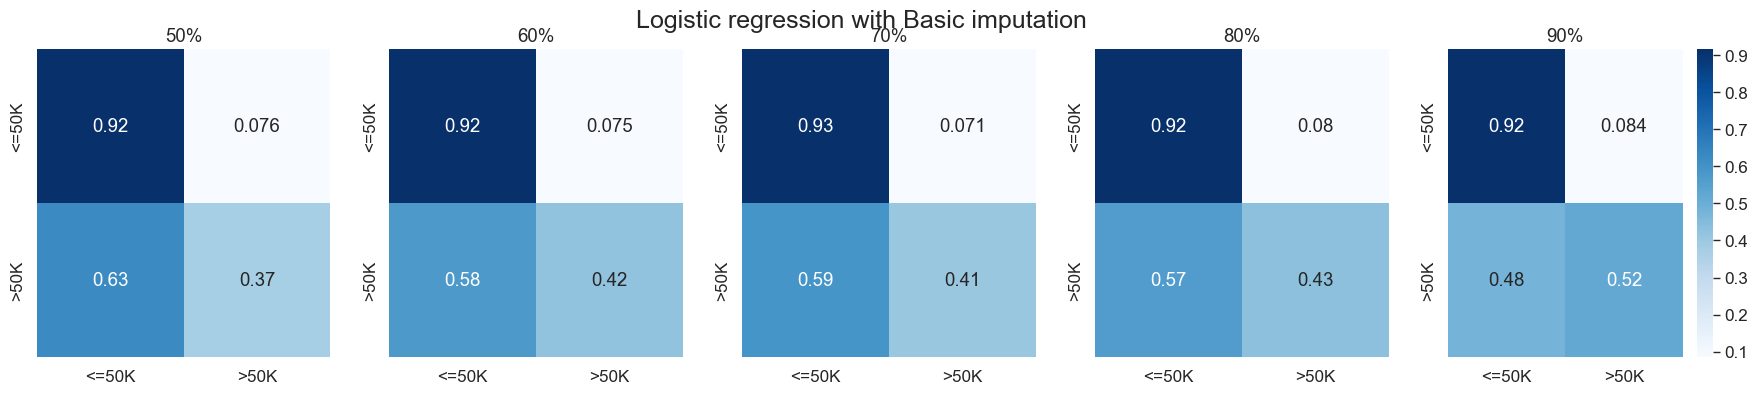

In [68]:
labels=['<=50K', '>50K']
percentages = [f'{p}%' for p in range(50, 100, 10)]

fig, axs = plt.subplots(ncols=5, figsize=(22,4))
fig.suptitle('Logistic regression with Basic imputation', fontsize=18)
for i in range(5):
    axs[i].set_title(percentages[i])
    sns.heatmap(basic_confusion_matrixes[i], annot=True, cmap='Blues',ax=axs[i], yticklabels=labels, xticklabels=labels, cbar=(i==4))
 

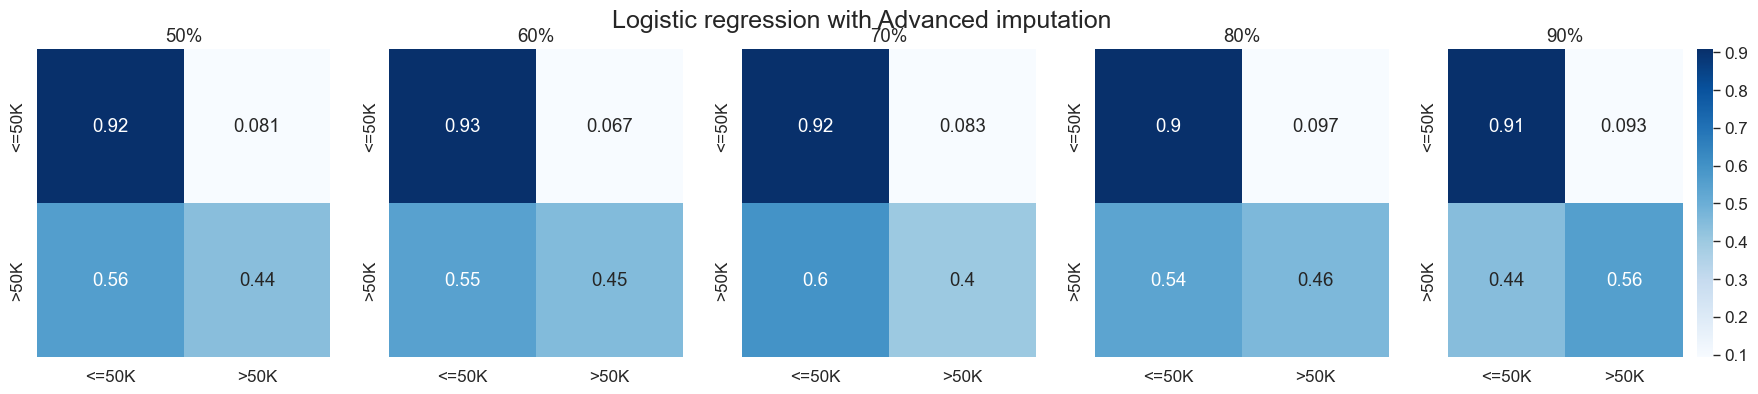

In [69]:
fig, axs = plt.subplots(ncols=5, figsize=(22,4))
fig.suptitle('Logistic regression with Advanced imputation', fontsize=18)
for i in range(5):
    axs[i].set_title(percentages[i])
    sns.heatmap(advanced_confusion_matrixes[i], annot=True, cmap='Blues',ax=axs[i], yticklabels=labels, xticklabels=labels, cbar=(i==4))

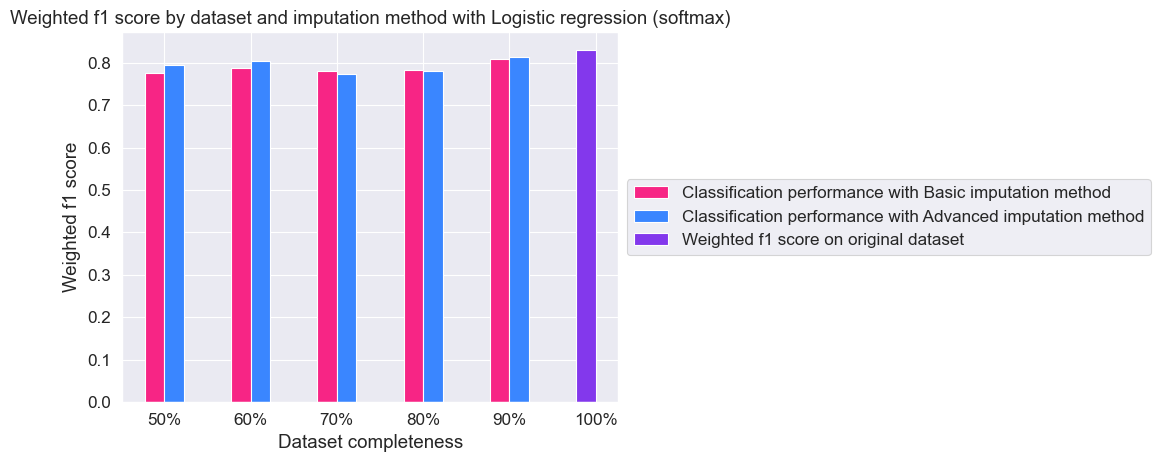

In [70]:
labels = [f'{p}%' for p in range(50, 110, 10)]

advanced_f1_plot = np.array(advanced_weighted_f1_score) 
basic_f1_plot = np.array(basic_weighted_f1_score) 

reference_f1_plot = reference_results[4] 

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x[:-1] - width/4, basic_f1_plot, width / 2, label='Classification performance with Basic imputation method', color='#f72585')
rects2 = ax.bar(x[: -1] + width/4, advanced_f1_plot, width / 2, label='Classification performance with Advanced imputation method', color='#3a86ff')

rect_reference = ax.bar(x[-1] - width/4, reference_f1_plot, width / 2, label='Weighted f1 score on original dataset', color='#8338ec')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weighted f1 score')
ax.set_xlabel('Dataset completeness')
ax.set_title('Weighted f1 score by dataset and imputation method with Logistic regression (softmax)')
ax.set_xticks(x, labels)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### SVM

In [71]:
from utility.utility import pipeline_ML, model_selection_SVM

basic_accuracies_svm = []
basic_reports_svm = []
basic_confusion_matrixes_svm = []
basic_weighted_f1_score_svm = []

advanced_accuracies_svm = []
advanced_reports_svm = []
advanced_confusion_matrixes_svm = []
advanced_weighted_f1_score_svm = []

for d in basic_df_transformed:
    results = pipeline_ML(d, 'income_>50K', seed, model_selection_SVM)
    basic_accuracies_svm.append(results[1])
    basic_reports_svm.append(results[2])
    basic_confusion_matrixes_svm.append(results[3])
    basic_weighted_f1_score_svm.append(results[4])
print('basic method tested')
    
for d in advanced_df_transformed:
    results = pipeline_ML(d, 'income_>50K', seed, model_selection_SVM)
    advanced_accuracies_svm.append(results[1])
    advanced_reports_svm.append(results[2])
    advanced_confusion_matrixes_svm.append(results[3])
    advanced_weighted_f1_score_svm.append(results[4])
print('advanced method tested')

reference_results_svm = pipeline_ML(reference_df_transformed, 'income_>50K', seed, model_selection_SVM)
print('reference tested')

basic method tested
advanced method tested
reference tested


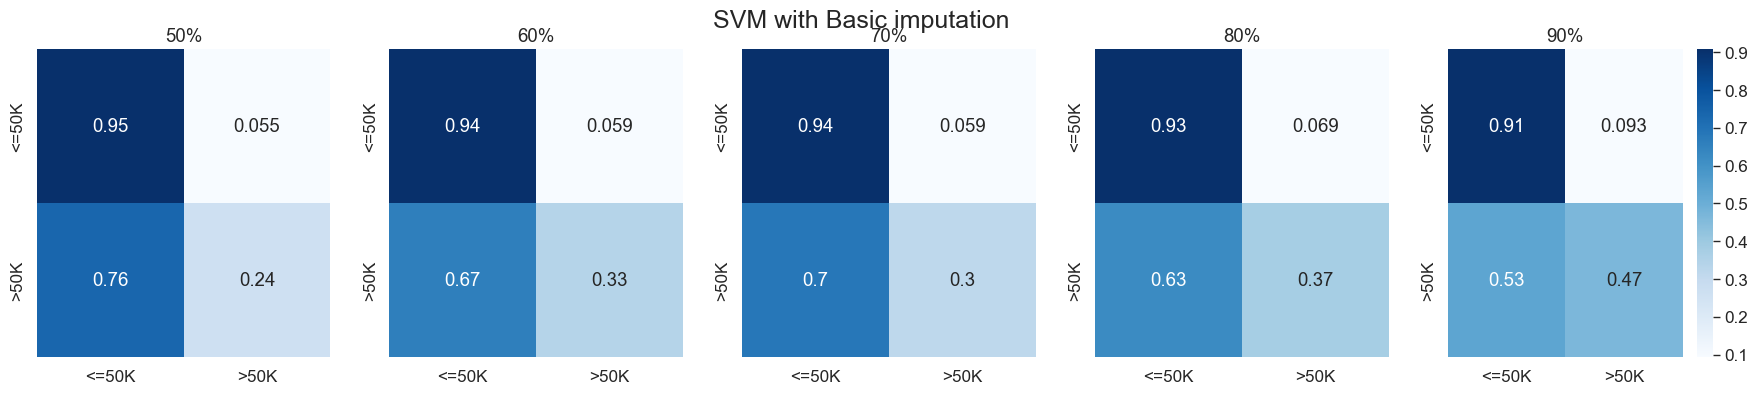

In [72]:
labels=['<=50K', '>50K']
percentages = [f'{p}%' for p in range(50, 100, 10)]

fig, axs = plt.subplots(ncols=5, figsize=(22,4))
fig.suptitle('SVM with Basic imputation', fontsize=18)
for i in range(5):
    axs[i].set_title(percentages[i])
    sns.heatmap(basic_confusion_matrixes_svm[i], annot=True, cmap='Blues',ax=axs[i], yticklabels=labels, xticklabels=labels, cbar=(i==4))


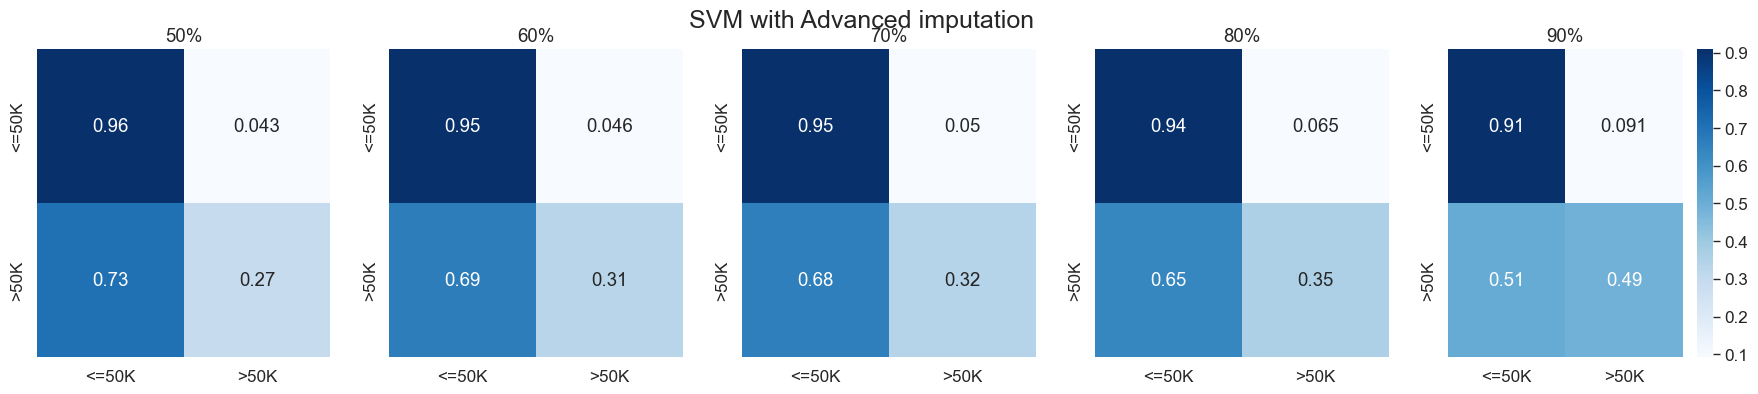

In [73]:
labels=['<=50K', '>50K']
percentages = [f'{p}%' for p in range(50, 100, 10)]

fig, axs = plt.subplots(ncols=5, figsize=(22,4))
fig.suptitle('SVM with Advanced imputation', fontsize=18)
for i in range(5):
    axs[i].set_title(percentages[i])
    sns.heatmap(advanced_confusion_matrixes_svm[i], annot=True, cmap='Blues',ax=axs[i], yticklabels=labels, xticklabels=labels, cbar=(i==4))


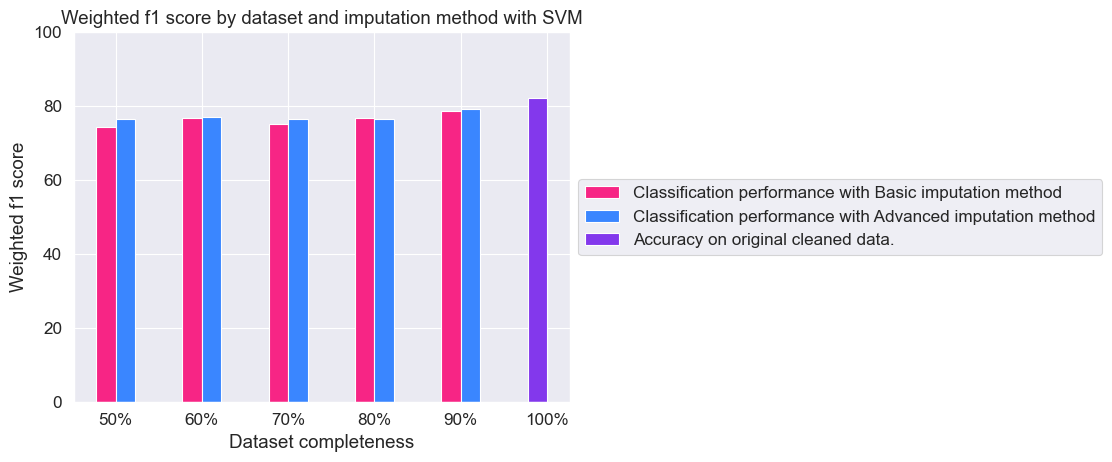

In [74]:
labels = [f'{p}%' for p in range(50, 110, 10)]

advanced_accuracies_plot = np.array(advanced_weighted_f1_score_svm) * 100
basic_accuracies_plot = np.array(basic_weighted_f1_score_svm) * 100

reference_accuracy_plot = reference_results_svm[1] * 100

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x[:-1] - width/4, basic_accuracies_plot, width / 2, label='Classification performance with Basic imputation method', color='#f72585')
rects2 = ax.bar(x[: -1] + width/4, advanced_accuracies_plot, width / 2, label='Classification performance with Advanced imputation method', color='#3a86ff')

rect_reference = ax.bar(x[-1] - width/4, reference_accuracy_plot, width / 2, label='Accuracy on original cleaned data.', color='#8338ec')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weighted f1 score')
ax.set_xlabel('Dataset completeness')
ax.set_title('Weighted f1 score by dataset and imputation method with SVM')
ax.set_xticks(x, labels)
plt.ylim((0, 100))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()